# Detecting Cancer in Gigapixel Medical Images
## Applied Deep Learning (Spring 2018) 
### Akarsh Zingade, Kiran Ramesh, Arjun D'Cunha

### YouTube [demo](https://www.youtube.com/watch?v=royB3p2m9pM). GitHub [repo](https://github.com/kira-95/adl_cancer_detection).

Note: The 22 slides and tumor masks prepared by Prof. Joshua Gordon can be found [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). The super set of this dataset can be found at [CAMELYON16](https://camelyon17.grand-challenge.org/Data/)


### Summary

We base our approach on the the work by Google AI's [Lui et al. (2017)](https://arxiv.org/abs/1703.02442) in "Detecting Cancer Metastases on Gigapixel Pathology Images". We use ImageNet pretrained architecture and then use transfer learning to solve the problem of detecting cancer cells in the images. We train it using a sliding-window based approach, where we train the model using the patches extracted using the sliding windows. Once the model is trained, we create a heatmap of the prediction on medical slides that were not used during training.


### Flow of the Notebook.

1. Load the dataset created by the Extract Notebook
2. Choose the following that is desired:
    a) Zoom Level of the slide.
    b) Sliding window size
    c) Architecture for training.
3. Performs two levels of transfer learning.
    a) Adds Dense layers to the pretrained, freeze the pretrained layers, train the newly added layers.
    b) Unfreeze all or few higher layers of the pretrained model, train the trainable layers.
4. Evalutate accuracy on extracted test images.
5. Load the test slides, run the heatmap prediction/generation.
6. Report F1, Recall, Precision, AUC score, Sensitivity, Specificity.


#### Train Slides: 031, 064, 075, 084, 091, 094, 096, 101
#### Test Slides:  016, 078, 110

In [ ]:
# from google.colab import drive
# try:
#   drive.mount('/content/gdrive')
# except: 
#   print ("already mounted")

In [ ]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0
# !apt-get -q install openslide-tools
# !pip -q install openslide-python

### Import the relevant modules. 
#### Import the Garbage Collection module to free objects

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray
import random
from sklearn import metrics
import sklearn
from sklearn.metrics import confusion_matrix
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score, precision_score

from matplotlib.colors import Normalize
import gc
gc.collect()

22

#### Check the available GPUs

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10068685055843378943
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6001817252520202121
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6892930285887157214
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15928269210
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6378152555256397390
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [3]:
# Define the level to be used for training the model.
lev = level = 4 

# Define the window size for the sliding window.
window_size = (299,299)

# Define the center size to label the patch as tumorous or as healthy.
center_size = (128, 128)

# Define the stride length for the sliding window
stride = 80

# path to save the model
model_filename = 'vgg19_level4_final_focal_loss.h5' 

# Model to select for training. Options: InceptionV3, VGG19, ResNet50
select_model = 'vgg19'

# path to the saved dataset
dataset_path = './dataset_final.npy'

# Load the dataset

dataset = np.load(dataset_path,allow_pickle=True)

X_train, X_val, y_train, y_val, X_test, y_test = np.asarray(dataset.item()['X_train']), np.asarray(dataset.item()['X_val']), np.asarray(dataset.item()['y_train']), np.asarray(dataset.item()['y_val']), np.asarray(dataset.item()['X_test']), np.asarray(dataset.item()['y_test'])  


print ((X_train.shape),(X_val.shape), y_train.shape, y_val.shape, (X_test.shape), y_test.shape)

(2880, 299, 299, 3) (720, 299, 299, 3) (2880,) (720,) (1200, 299, 299, 3) (1200,)


In [4]:
del dataset
gc.collect()

18

In [5]:
# Get the count of images for each class across train, val and test dataset

try:
  unique, counts = np.unique(np.argmax(y_train,axis=1), return_counts=True)
except:
  unique, counts = np.unique(y_train, return_counts=True)
print ('Train class split: ', dict(zip(unique, counts)))
try:
  unique, counts = np.unique(np.argmax(y_val,axis=1), return_counts=True)
except:
  unique, counts = np.unique(y_val, return_counts=True)
print ('Train class split: ',dict(zip(unique, counts)))

try:
  unique, counts = np.unique(np.argmax(y_test,axis=1), return_counts=True)
except:
  unique, counts = np.unique(y_test, return_counts=True)
print ('Train class split: ', dict(zip(unique, counts)))


{0: 1440, 1: 1440}
{0: 360, 1: 360}
{0: 600, 1: 600}


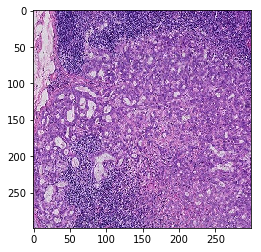

In [6]:
# Show one of the train patches.

plt.imshow(X_train[2])

In [7]:
# Define the preprocessing function required for the model

def inception_preprocess_input(x):
    x = x.astype(float)
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

select_model = 'vgg19'#'vgg19'#'inception'  

if select_model == 'inception':
  base_model = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False)
  preprocess_input = inception_preprocess_input
elif select_model == 'resnet50':
  base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
  preprocess_input = tf.keras.applications.vgg19.preprocess_input#inception_preprocess_input#tf.keras.applications.vgg19.preprocess_input#inception_preprocess_input#tf.keras.applications.ResNet50.preprocess_input
elif select_model == 'vgg19':
  base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  preprocess_input = tf.keras.applications.vgg19.preprocess_input

# Define the architecture built on top of the ImageNet pretrained model.

x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x=tf.keras.layers.Dense(256,activation='relu')(x) 
out=tf.keras.layers.Dense(1,activation='sigmoid')(x)
model=tf.keras.models.Model(inputs=base_model.input,outputs=out)    
print (model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [8]:
# Define the train, validation, test data generator functions.  
  
BATCH_SIZE = 128


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip = True, vertical_flip = True, preprocessing_function=preprocess_input)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)
test_generator = train_datagen.flow(X_test, y_test, batch_size=32, shuffle=True)

In [9]:
# 1st level Transfer learning where you train just the added dense layer while freezing the pretrained layers

for layer in base_model.layers:
  layer.trainable = False

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  min_delta=0.001,
                                                  patience=3,
                                                  verbose=1)

history = model.fit_generator(train_generator,
                              steps_per_epoch=int(len(X_train)/BATCH_SIZE)+1,
                              epochs=5,
                              validation_data=val_generator,
                              validation_steps=int(len(X_val)/BATCH_SIZE)+1 , callbacks=[early_stopping])

Epoch 1/5
23/23 [==============================] - 29s 1s/step - loss: 0.6103 - accuracy: 0.7347 - val_loss: 0.2885 - val_accuracy: 0.8681
Epoch 2/5
23/23 [==============================] - 21s 895ms/step - loss: 0.3595 - accuracy: 0.8392 - val_loss: 0.2395 - val_accuracy: 0.8931
Epoch 3/5
23/23 [==============================] - 21s 892ms/step - loss: 0.2981 - accuracy: 0.8747 - val_loss: 0.2198 - val_accuracy: 0.9153
Epoch 4/5
23/23 [==============================] - 21s 895ms/step - loss: 0.3000 - accuracy: 0.8774 - val_loss: 0.1933 - val_accuracy: 0.9208
Epoch 5/5
23/23 [==============================] - 21s 893ms/step - loss: 0.2584 - accuracy: 0.8934 - val_loss: 0.1812 - val_accuracy: 0.9333


In [10]:
# Compute the test accuracy

test_loss, test_acc = model.evaluate_generator(test_generator, steps=int(len(X_test)/BATCH_SIZE)+1)
print('Test loss: %.3f, accuracy: %.3f' % (test_loss, test_acc))

Test loss: 0.187, accuracy: 0.928


In [11]:
# 2nd level Transfer learning where you unfreeze all or few of the top pretrained layers and train. 

if select_model == 'inception':
  for layer in model.layers[:172]: 
    layer.trainable = False 

  for layer in model.layers[172:]: 
    layer.trainable = True
    
else:
  for layer in model.layers: 
    layer.trainable = True



model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  min_delta=0.001,
                                                  patience=3,
                                                  verbose=1)

history = model.fit_generator(train_generator,
                              steps_per_epoch=int(len(X_train)/BATCH_SIZE)+1,
                              epochs=5,
                              validation_data=val_generator,
                              validation_steps=int(len(X_val)/BATCH_SIZE)+1 ,callbacks=[early_stopping])

Epoch 1/5
23/23 [==============================] - 79s 3s/step - loss: 0.2175 - accuracy: 0.9125 - val_loss: 0.1376 - val_accuracy: 0.9486
Epoch 2/5
23/23 [==============================] - 70s 3s/step - loss: 0.1325 - accuracy: 0.9458 - val_loss: 0.0659 - val_accuracy: 0.9778
Epoch 3/5
23/23 [==============================] - 70s 3s/step - loss: 0.0911 - accuracy: 0.9684 - val_loss: 0.0549 - val_accuracy: 0.9806
Epoch 4/5
23/23 [==============================] - 70s 3s/step - loss: 0.0688 - accuracy: 0.9760 - val_loss: 0.0540 - val_accuracy: 0.9833
Epoch 5/5
23/23 [==============================] - 70s 3s/step - loss: 0.0740 - accuracy: 0.9740 - val_loss: 0.0411 - val_accuracy: 0.9833


In [12]:
del X_train, X_val, y_train, y_val
gc.collect()

33159

In [13]:
# Compute the test accuracy

test_loss, test_acc = model.evaluate_generator(test_generator, steps=int(len(X_test)/BATCH_SIZE)+1)
print('Test loss: %.3f, accuracy: %.3f' % (test_loss, test_acc))

Test loss: 0.041, accuracy: 0.981


In [16]:
# Save the model

model_filename = 'vgg19_final.h5' 
model_filename = os.path.join('./model', model_filename)
model.save(model_filename)

In [ ]:
# Load the saved model

# model_filename = 'vgg19_200_MODEL.h5' 
# model_filename = os.path.join('./model', model_filename)
# #model.load(model_filename)
# model = load_model(model_filename)

### Heat Map Generation on Test Slides

In [14]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    """
    Read the slide
    """
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
  
def find_tissue_pixels(image, intensity=0.8):
    """ Return tissue pixels for an image
    """
    
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])
  
def apply_mask(im, mask, color=(255,0,0)):
    """
    Create mask for the image using the mask
    
    im: input image
    mask: Mask for the image
    """
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked
  
def check_patch_centre(patch_mask, patch_centre):
    """ Check if there is any tumor pixel in the 128x128 centre
    inputs:
    - patch_mask: array, tumor mask
    - patch_centre: int, usually 128
    outputs: Boolean
    """

    offset = int((patch_mask.shape[0]-patch_centre)/2)
    
    sum_ = np.sum(patch_mask[offset:offset+patch_centre, offset:offset+patch_centre])
    
    return sum_>0
  

def get_pred(slide_path, lvl, window_size = (299,299), center_size = (128, 128), stride = 40):
    """
    Predict whether a patch is tumorous 
    
    slide_path: Path to the slide.
    lvl: The level at which the predictions are being evaluated
    window_size: Sliding Window size
    center_size: Center size to label the patch as tumorous or as healthy.
    stride: Stride for the sliding window

    """
    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                            slide.level_dimensions[0][0], 
                                                            slide.level_dimensions[0][1]))
        
    patch_images = []
    preds = []
    count = 0
    patch_coord= []
    
    slide_image = read_slide(slide, 
                       x=0, 
                       y=0, 
                       level=lvl, 
                       width=slide.level_dimensions[lvl][0], 
                       height=slide.level_dimensions[lvl][1])
    
    
    

    for i in range(0, slide.level_dimensions[lvl][1] - window_size[0] - stride, stride):
      for j in range(0, slide.level_dimensions[lvl][0] - window_size[1] - stride, stride):
        count += 1

        patch = slide_image[i:i+window_size[0], j:j+window_size[1]]

        tissue_pixels = find_tissue_pixels(patch)
        tissue_pixels = list(tissue_pixels)
        percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[0]) * 100

        if percent_tissue > 50.:
          patch_images.append(patch.astype('float32'))
          patch_coord.append([i,j])

        if count % 500 == 0:
          print(count, end=', ')
        if len(patch_images) != 0 and len(patch_images) == 256:
          patch_images = np.asarray(patch_images)#,axis = 0)
          patch_images = preprocess_input(patch_images)#/= 255.
          y_pred = model.predict(patch_images)
          if len(y_pred[0]) == 2:
            y_pred = np.argmax(y_pred,axis = 1)
          preds += list(y_pred)
          patch_images = []

    if len(patch_images) != 0:
          patch_images = np.asarray(patch_images)#,axis = 0)
          patch_images  = preprocess_input(patch_images)#/= 255.
          y_pred = model.predict(patch_images)
          if len(y_pred[0]) == 2:
            y_pred = np.argmax(y_pred,axis = 1)
          preds += list(y_pred)
          patch_images = []
          
    return preds, patch_coord
  
  
def evaluate_pred(slide_path, tumor_mask_path, preds, patch_coord, level=4):
  """
  Evaluate the predictions. 
  slide_path: Path to the slide.
  tumor_mask_path: Path to the tumor mask slide
  preds: Predictions of the test slide
  patch_coord: Patch Coordinates of the predictions
  level: The level at which the predictions are being evaluated
  
  """
  slide = open_slide(slide_path)


  tumor_mask = open_slide(tumor_mask_path)

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
  slide_image = np.asarray(read_slide(slide, x=0, y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1]))
  mask_image = np.asarray(read_slide(tumor_mask, x=0, y=0, 
                          level=level, 
                          width=slide.level_dimensions[level][0], 
                          height=slide.level_dimensions[level][1]))



  mask_pred=np.zeros_like(mask_image[:,:,0])
  for idx, (i,j) in enumerate(patch_coord):
    mask_pred[i:i+window_size[0], j:j+window_size[1]] = 0. if preds[idx]<0.5 else 255.#preds[idx] * 255.

  plt.figure(figsize=(18,10))
  plt.subplot(1,3,1)
  plt.imshow(slide_image)
  plt.imshow(mask_image[:,:,0],cmap='jet', alpha=0.5)
  plt.grid(False)
  plt.subplot(1,3,2)
  plt.imshow(slide_image)
  plt.imshow(mask_pred, cmap='jet',alpha=0.5) # Red regions contains cancer.
  plt.grid(False)
  plt.subplot(1,3,3)
  plt.imshow(mask_image[:,:,0])
  plt.imshow(mask_pred, cmap='jet',alpha=0.5) # Red regions contains cancer.
  plt.grid(False)
  plt.show()

  fpr, tpr, thresholds = metrics.roc_curve(mask_image[:,:,0].reshape(-1).astype('float32'), 
                                           mask_pred.reshape(-1), pos_label=None)
  print('AUC:%s'%(metrics.auc(fpr, tpr)))
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.plot(fpr, tpr)
  plt.show()

  thres = thresholds[np.argmax(1-fpr+tpr)]
  print ("Threshold: ", thres)
  print('Sensitivity:{}'.format(tpr[np.argmax(1-fpr+tpr)]))
  print('Specificity:{}'.format((1-fpr)[np.argmax(1-fpr+tpr)]))

  mask_pred_labels = np.zeros(mask_pred.shape)
  mask_pred_labels[mask_pred >= thres] = 1.
  mask_pred_labels[mask_pred < thres] = 0.
  
  mask_image = mask_image[:,:,0].reshape(-1).astype('uint8')
  mask_pred_labels = mask_pred_labels.reshape(-1).astype('uint8')
  mat = confusion_matrix(mask_image, mask_pred_labels)
  del mask_image, mask_pred_labels
  gc.collect()
  print('--------Confusion Matrix------')
  print(mat)

  recall = mat[1][1]/(mat[1][1]+mat[1][0])  
  precision = mat[1][1]/(mat[1][1]+mat[0][1])
  F1 = 2 * (precision * recall) / (precision + recall)

  print('Recall:{}'.format(recall))
  print('Precision:{}'.format(precision))
  print ("F1 Score:{}".format(F1))
  
  return mat, recall, precision, F1

Read WSI from ./slides/tumor_110.tif with width: 94208, height: 71680
500, 1000, 1500, 2000, 2500, 3000, 3500, 

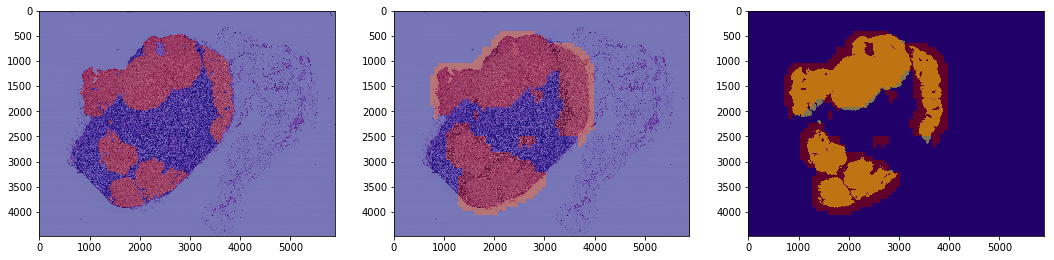

AUC:0.9317873745614184


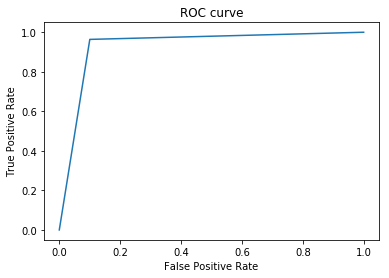

Threshold:  255
Sensitivity:0.963821066543782
Specificity:0.899753682579055
--------Confusion Matrix------
[[20033902  2232083]
 [  148777  3963478]]
Recall:0.963821066543782
Precision:0.6397286702527826
F1 Score:0.7690238164903215
Read WSI from ./slides/tumor_016.tif with width: 97792, height: 221184
500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 

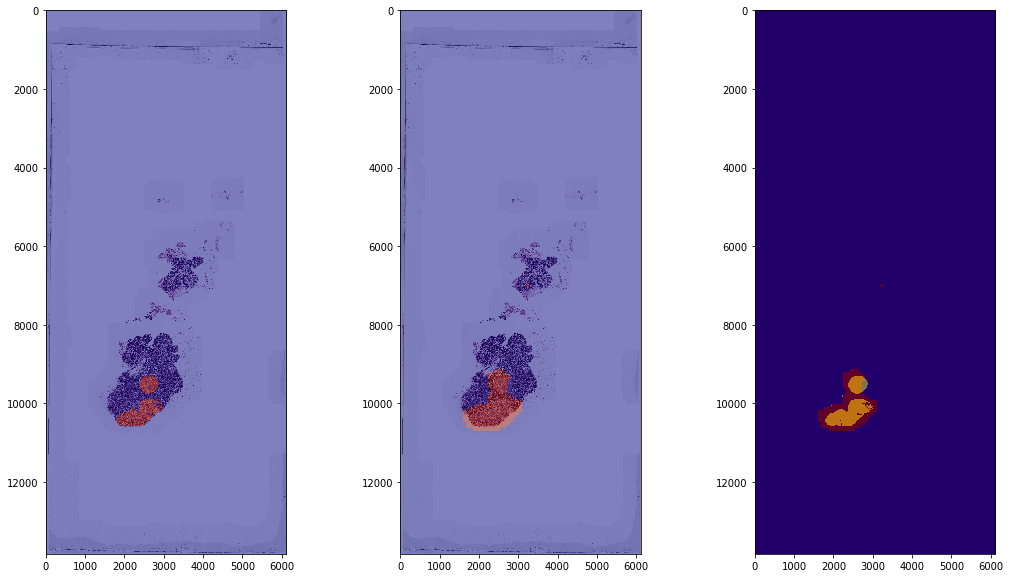

AUC:0.9715362373605867


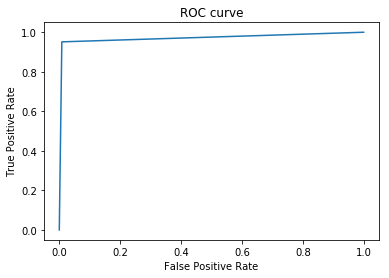

Threshold:  255
Sensitivity:0.9514001156343724
Specificity:0.9916723590868011
--------Confusion Matrix------
[[83166054   698393]
 [   30513   597328]]
Recall:0.9514001156343724
Precision:0.46100047772630065
F1 Score:0.6210644626999285
Read WSI from ./slides/tumor_078.tif with width: 94208, height: 111104
500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 

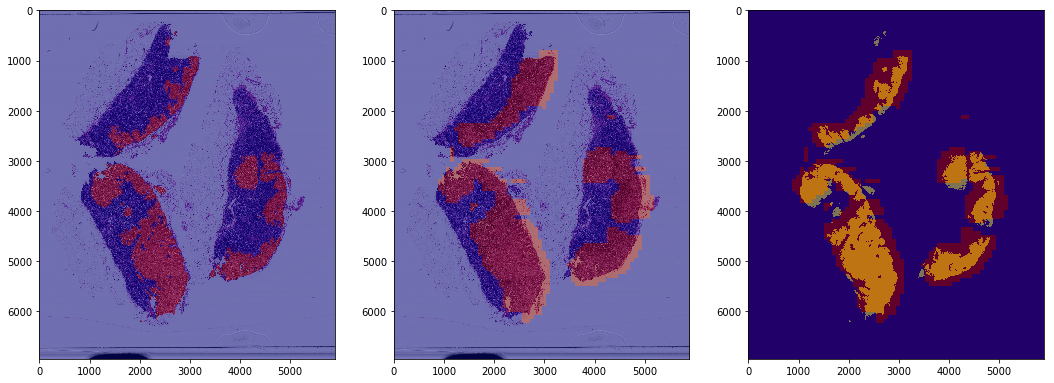

AUC:0.9020853119703005


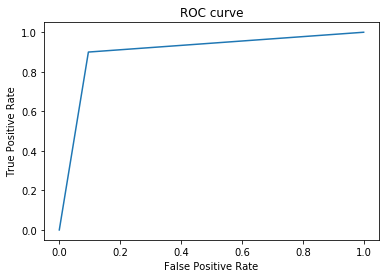

Threshold:  255
Sensitivity:0.8997665623658669
Specificity:0.9044040615747342
--------Confusion Matrix------
[[33547418  3545978]
 [  380173  3412703]]
Recall:0.8997665623658669
Precision:0.4904238317577713
F1 Score:0.6348295414329292


In [15]:
# Generate heat maps for test slides. 

SLIDES = ['110','016','078']
level = 4
window_size = (299,299)
center_size = (128, 128)
stride = 80
for slide_num in SLIDES:
  slide_path = './slides/tumor_'+slide_num+'.tif'
  tumor_mask_path = './slides/tumor_'+slide_num+'_mask.tif'

  
  preds, patch_coord = get_pred(slide_path, level, window_size, center_size, stride)
  conf_mat, recall, precision, F1 = evaluate_pred(slide_path, tumor_mask_path, preds, patch_coord, level)